#### In this question we analyze the data file **Fertility.csv** which is available in the homework folder, and try to build a model for fertility. In this dataset Fertility, the first column, is the response variable, and the other variables are potential predictors. We will use several different statistical modeling techniques. The data set contains 47 rows (samples), split the data into training and test sets. Set the first 30 rows to training samples and the rows 31 through 47 as the test samples.

In [1]:
import numpy as np
import pandas as pd
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import subplots

In [2]:
Data = pd.read_csv('Fertility.csv')
# print(Data)
train = (Data.index < 30)
X = MS(Data.columns.drop(['Fertility'])).fit_transform(Data)
Y = Data['Fertility']
y_train, X_train = Y.loc[train] , X.loc[train]
y_test, X_test = Y.loc[~train] , X.loc[~train]

#### (a) Fit a linear model on the training set, and report the test error (MSE) obtained.

In [3]:
LinearModel = LinearRegression()
LinearModel.fit(X_train, y_train)
y_pred_linear = LinearModel.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
# print(pd.DataFrame({'y':y_test, 'pred':pred_linear}))
print('MSE Linear:', mse_linear)

MSE Linear: 183.72179150160574


#### (b) Fit a Ridge regression model on the training set, with λ chosen by cross-validation on a dense grid similar to the example solved in the class. Report the test error obtained.

In [4]:
if 'intercept' in X:
    X = X.drop(columns=['intercept'], axis = 1)
X_np = X.to_numpy()
Xs = X_np - X_np.mean(0)[None,:]
X_scale = X_np.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(10, -10, 100) / Y.std()

In [5]:
param_grid = {'ridge__alpha': lambdas}
K = 5
kfold = skm.KFold(K, random_state=0, shuffle=True)
scaler = StandardScaler(with_mean=True,  with_std=True)

ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X, Y)

/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3072.5159407502, tolerance: 0.6145031891891891
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([8.00531736e+08, 5.02757261e+08, 3.15746212e+08, 1.98297823e+08,
       1.24536812e+08, 7.82127477e+07, 4.91198850e+07, 3.08487193e+07,
       1.93738948e+07, 1.21673706e+07, 7.64146333e+06, 4.79906167e+06,
       3.01395060e+06, 1.89284881e+06, 1.18876422e+06, 7.46578576e+05,
       4.68873104e+05, 2.94465974e+05,...
       5.51775473e-08, 3.46531078e-08, 2.17631616e-08, 1.36678998e-08,
       8.58383940e-09, 5.39090131e-09, 3.38564314e-09, 2.12628256e-09,
       1.33536742e-09, 8.38649657e-10, 5.26696426e-10, 3.30780706e-10,
       2.07739924e-10, 1.30466726e-10, 8.19369065e-11, 5.14587653e-11,
       3.23176043e-11, 2.02963974e-11, 1.27467291e-11, 8.00531736e-12]),
                              cv=KFold(n_splits=5, random_state=0, shuffle=True),
                              l1_ratio=0))])

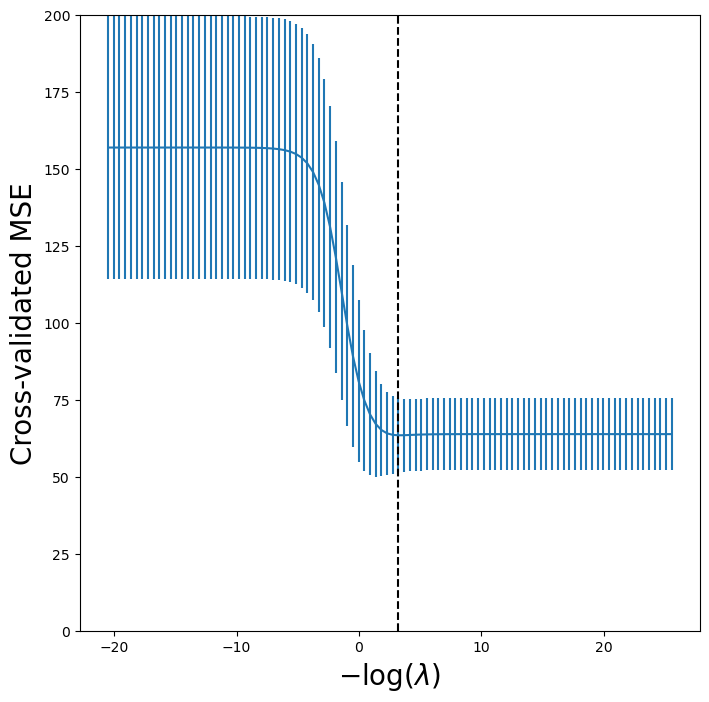

In [6]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([0,200])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [7]:
print("The smallest test error for Ridge:", np.min(tuned_ridge.mse_path_.mean(1)))

The smallest test error for Ridge: 63.45187653970055


#### (c) Fit a LASSO model on the training set, with λ chosen by cross-validation on a dense grid similar to the example solved in the class. Report the test error obtained, along with the number of non-zero coefficient estimates.

In [8]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.06653839184028286

In [9]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
# soln_path = pd.DataFrame(soln_array.T,
#                          columns=X.columns,
#                          index=-np.log(lambdas))

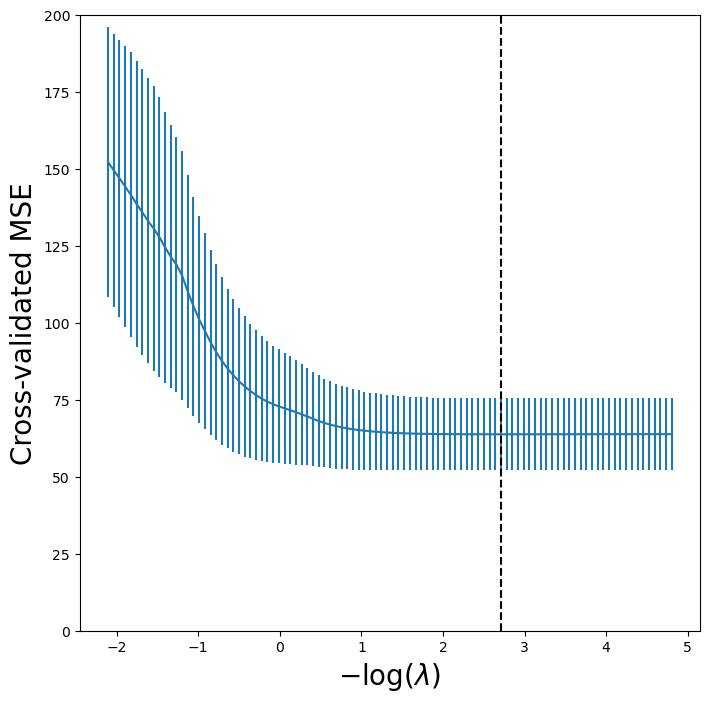

In [10]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0,200])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [11]:
# tuned_lasso.mse_path_
print("The smallest test error for LASSO:", np.min(tuned_lasso.mse_path_.mean(1)))

The smallest test error for LASSO: 63.772950878902805


In [12]:
print('The number of non-zero coefficient estimates:',np.sum(tuned_lasso.coef_ != 0))

The number of non-zero coefficient estimates: 5


#### (d) Compare the results of (a), (b), and (c). Which one seems to outperform the others for this specific setup?

#### In this case, the Linear Model got the highest test error(MSE). The results of Ridge and LASSO are pretty close and all around 63.5. The LASSO did not drop any features, which means that none of the features are useless.